# Question 1

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Step a

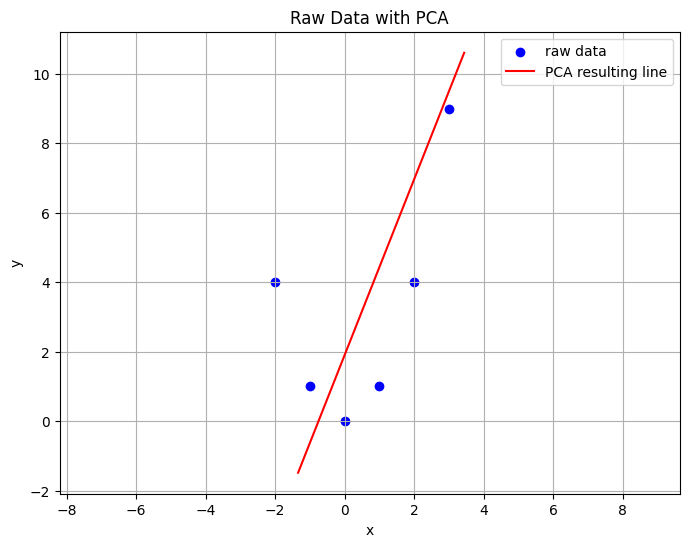

Raw Data (x, y) :
   x  y
0 -2  4
1 -1  1
2  0  0
3  1  1
4  2  4
5  3  9

mwan:
[0.5        3.16666667]

SVD Decomposition：

 Left Singular Vectors U:
         U1        U2
0 -0.018376  0.808965
1 -0.326589  0.183890
2 -0.398130 -0.215068
3 -0.232998 -0.387910
4  0.168808 -0.334634
5  0.807286 -0.055242

 Singular Values S:
   Singular Values
0          7.85835
1          3.25264

 Right Singular Vectors V^T：
          x         y
0  0.367738  0.929929
1 -0.929929  0.367738


In [20]:
# create x
x_vals = np.array([-2, -1, 0, 1, 2, 3])
# y = x^2
y_vals = x_vals ** 2

# step 1: generate data
data = np.column_stack((x_vals, y_vals))

# Step 2: Mean center
mean = np.mean(data, axis=0)
centered_data = data - mean

# --- 3. SVD ---
# centered_data = U * S * V^T
U, S, Vt = np.linalg.svd(centered_data)
PCs = Vt.T  # columns = principal directions

principal_component = Vt[0]

# t 参数控制直线上各个点的位置
t = np.linspace(-5, 8, 100)
# 每个直线上的点为：mean + t * principal_component
line = mean + t[:, None] * principal_component



# --- plot ---
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], color='blue', label='raw data')
plt.plot(line[:, 0], line[:, 1], color='red', label='PCA resulting line')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Raw Data with PCA')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# --- 6. present SVD  ---

# U
U_df = pd.DataFrame(U[:, :2], columns=["U1", "U2"])
# S
S_df = pd.DataFrame(S[:2], columns=["Singular Values"])
# V^T
Vt_df = pd.DataFrame(Vt, columns=["x", "y"])

print("Raw Data (x, y) :")
print(pd.DataFrame(data, columns=['x', 'y']))

print("\nmwan:")
print(mean)

print("\nSVD Decomposition：")
print("\n Left Singular Vectors U:")
print(U_df)
print("\n Singular Values S:")
print(S_df)
print("\n Right Singular Vectors V^T：")
print(Vt_df)




Step b

 Regression Line

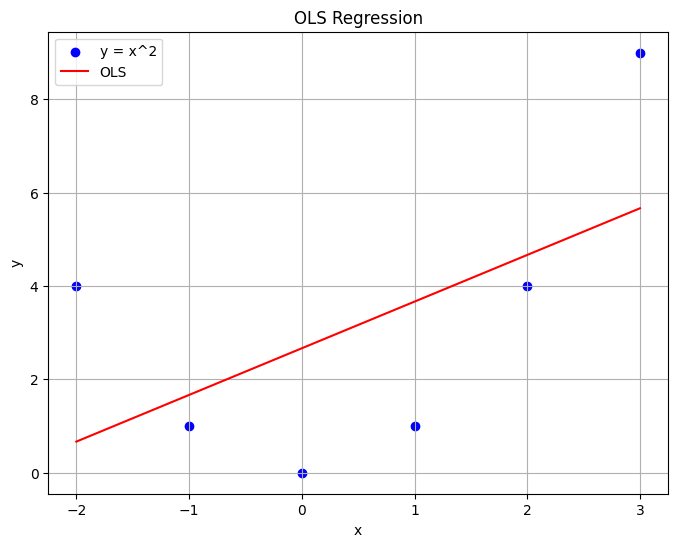

In [21]:
from sklearn.linear_model import LinearRegression

X = x_vals.reshape(-1, 1)

# --- regression model ---
model = LinearRegression()
model.fit(X, y_vals)
y_pred = model.predict(X)

# --- Plot OLS ---
plt.figure(figsize=(8, 6))
plt.scatter(x_vals, y_vals, color='blue', label='y = x^2')
plt.plot(x_vals, y_pred, color='red', label='OLS')
plt.xlabel('x')
plt.ylabel('y')
plt.title('OLS Regression')
plt.legend()
plt.grid(True)
plt.show()

# Question 2

In [22]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.neighbors import NearestNeighbors

data_2 = np.array([
    [0, 0],
    [1, 1],
    [2, 2],
    [3, 3],
    [4, 4],
    [5, 5]
])


For each points, Identify the 2 nearest neighbors:
  - For (0,0): its two nearest neighbors are (1,1) and (2,2).
  - For (1,1): its two nearest neighbors are (0,0) and (2,2).
  - For (2,2): its two nearest neighbors are (1,1) and (3,3).
  - For (3,3): its two nearest neighbors are (2,2) and (4,4).
  - For (4,4): its two nearest neighbors are (3,3) and (5,5).
  - For (5,5): its two nearest neighbors are (4,4) and (3,3).

Compute the reconstruction weights for each point from its neighbors.

In [23]:
def compute_reconstruction_weights(X, point_index, n_neighbors):

  # get Nearest Neighbors
  nbrs = NearestNeighbors(n_neighbors=n_neighbors+1).fit(X)
  distances, indices = nbrs.kneighbors([X[point_index]])

  # get Nearest Neighbors index
  mask = indices[0] != point_index
  neighbor_indices = indices[0][mask][:n_neighbors]

  # shape：(n_neighbors, n_features)
  x_i = X[point_index]
  neighbors = X[neighbor_indices]
  Z = neighbors - x_i


  C = Z @ Z.T

  reg = 1e-3 * np.trace(C)
  C = C + np.eye(n_neighbors) * reg

  ones = np.ones(n_neighbors)
  w = np.linalg.solve(C, ones)
  w = w / np.sum(w)

  return w, neighbor_indices

n_neighbors = 2
for point_index in range(6):
  weights, neighbor_indices = compute_reconstruction_weights(data_2, point_index, n_neighbors)
  print("Indices of neighbors:", neighbor_indices)
  print("Reconstruction weights:", weights)

Indices of neighbors: [1 2]
Reconstruction weights: [ 1.98514851 -0.98514851]
Indices of neighbors: [0 2]
Reconstruction weights: [0.5 0.5]
Indices of neighbors: [1 3]
Reconstruction weights: [0.5 0.5]
Indices of neighbors: [2 4]
Reconstruction weights: [0.5 0.5]
Indices of neighbors: [3 5]
Reconstruction weights: [0.5 0.5]
Indices of neighbors: [4 3]
Reconstruction weights: [ 1.98514851 -0.98514851]


Compute the 1-dimensional embeddings by solving the eigenproblem

1D Coordinates of the six points:
Point [-2  4] -> 0.5968
Point [-1  1] -> 0.3598
Point [0 0] -> 0.1199
Point [1 1] -> -0.1199
Point [2 4] -> -0.3598
Point [3 9] -> -0.5968


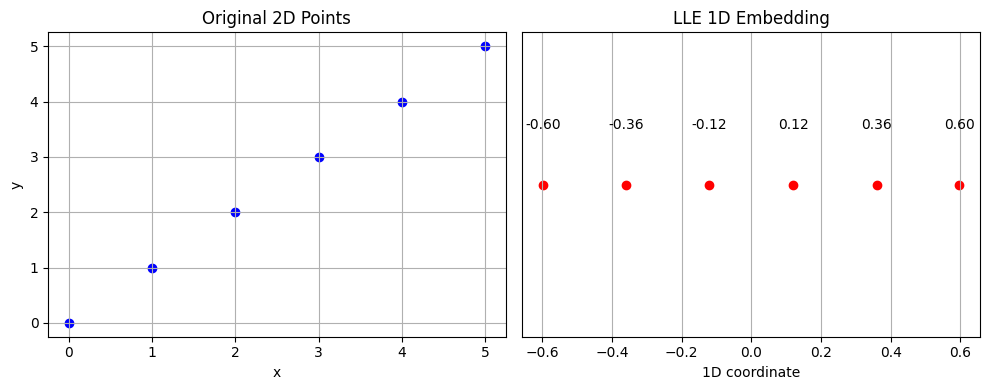

In [24]:
# Apply LLE
n_neighbors = 2
lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=1)
X_lle = lle.fit_transform(data_2)

print("1D Coordinates of the six points:")
for idx, coord in enumerate(X_lle.flat):
    print(f"Point {data[idx]} -> {coord:.4f}")

# Step 6: Visualization
# ===============================
# Plot original 2D points and the 1D embedding along a horizontal line to show ordering.
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(data_2[:, 0], data_2[:, 1], color='blue')
plt.title('Original 2D Points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(X_lle, np.zeros_like(X_lle), color='red')
for i, coord in enumerate(X_lle.flat):
    plt.text(coord, 0.02, f"{coord:.2f}", ha='center')
plt.title('LLE 1D Embedding')
plt.xlabel('1D coordinate')
plt.yticks([])
plt.grid(True)

plt.tight_layout()
plt.show()

Explanation
The LLE transformation finds a 1D representation which preserves the local structure. In this case, since the 2D points all lie on the line y=x, their ordering is preserved, and the resulting 1D coordinates are essentially a linear transformation of the original coordinate, and maintain the attribute of same distance between each points, which shows that LLE successfully preserve the local relationships among points.

# Problem 3

In [25]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

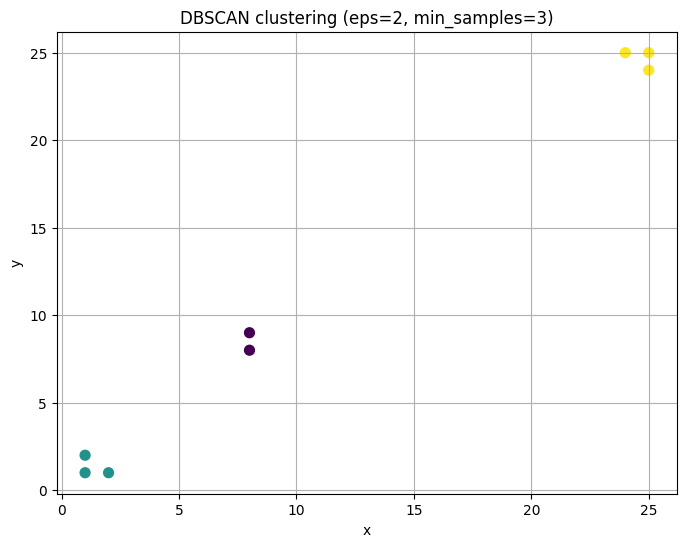

DBSCAN clustering (eps=2, min_samples=2) result：
Num of Clusters： 2

Points of each cluster:
Cluster 0: ['A', 'B', 'C']
Cluster 1: ['F', 'G', 'H']

Each Points：
Point A (Position [1 1]): core
Point B (Position [2 1]): core
Point C (Position [1 2]): core
Point D (Position [8 8]): noise
Point E (Position [8 9]): noise
Point F (Position [25 25]): core
Point G (Position [24 25]): core
Point H (Position [25 24]): core


In [26]:
X_3 = np.array([
    [1, 1],
    [2, 1],
    [1, 2],
    [8, 8],
    [8, 9],
    [25, 25],
    [24, 25],
    [25, 24]
])

y = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])

eps_val = 2        # epsilon
min_pts = 3        # minimum number of points

# DBSCAN
dbscan = DBSCAN(eps=eps_val, min_samples=min_pts)
labels = dbscan.fit_predict(X_3)


plt.figure(figsize=(8, 6))
plt.scatter(X_3[:, 0], X_3[:, 1], c=labels, cmap='viridis', s=50)
plt.title(f"DBSCAN clustering (eps={eps_val}, min_samples={min_pts})")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


# --- cores、border、noise ---
core_indices = dbscan.core_sample_indices_
core_mask = np.zeros_like(labels, dtype=bool)
core_mask[core_indices] = True


point_classification = []
for i in range(len(X_3)):
    if labels[i] == -1:
        status = "noise"
    else:
        if core_mask[i]:
            status = "core"
        else:
            status = "border"
    point_classification.append(status)


# --- determine how many clusters are formed ---
unique_labels = set(labels) - {-1}
num_clusters = len(unique_labels)

# list the points belonging to each cluster
clusters = {}
for cl in unique_labels:
    clusters[cl] = np.where(labels == cl)[0]

# --- print ---
print("DBSCAN clustering (eps=2, min_samples=2) result：")
print("Num of Clusters：", num_clusters)
print()

print("Points of each cluster:")
for cl, indices in clusters.items():
    print(f"Cluster {cl}: {y[indices].tolist()}")

print()
print("Each Points：")
for i, status in enumerate(point_classification):
    print(f"Point {y[i]} (Position {X_3[i]}): {status}")


# Problem 4

In [27]:
nodes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
node_index = {node: i for i, node in enumerate(nodes)}
n = len(nodes)

# initialize n x n
A = np.zeros((n, n))

edges = [
    ('A', 'B'),
    ('A', 'C'),
    ('B', 'C'),
    ('B', 'D'),
    ('C', 'D'),
    ('D', 'E'),
    ('E', 'F'),
    ('E', 'G'),
    ('F', 'G'),
    ('F', 'H'),
    ('G', 'H')
]


# Construct the (symmetric) adjacency matrix for this graph
for u, v in edges:
    i, j = node_index[u], node_index[v]
    A[i, j] = 1
    A[j, i] = 1

print("Original adjacency matrix A:")
print(A)

Original adjacency matrix A:
[[0. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1. 0.]]


In [28]:
# ----------------------------
# SVD decomposition
# ----------------------------
U, S, VT = np.linalg.svd(A)

print("\nSingular Values:")
print(S.tolist())


Singular Values:
[2.8136065026483297, 2.414213562373095, 2.0000000000000004, 1.3429230827771703, 1.0000000000000004, 1.0, 0.5293165801288396, 0.4142135623730949]


In [29]:
r = 2  # keep only 2 singular values
U_r = U[:, :r]
S_r = np.diag(S[:r])
VT_r = VT[:r, :]

A_approx = U_r @ S_r @ VT_r

print("\nThe adjacency matrix (retaining the top 2 singular values):")
print(np.round(A_approx, 2))


The adjacency matrix (retaining the top 2 singular values):
[[ 0.46  0.6   0.6   0.49  0.1  -0.06 -0.06 -0.08]
 [ 0.6   0.78  0.78  0.65  0.18 -0.02 -0.02 -0.06]
 [ 0.6   0.78  0.78  0.65  0.18 -0.02 -0.02 -0.06]
 [ 0.49  0.65  0.65  0.6   0.32  0.18  0.18  0.1 ]
 [ 0.1   0.18  0.18  0.32  0.6   0.65  0.65  0.49]
 [-0.06 -0.02 -0.02  0.18  0.65  0.78  0.78  0.6 ]
 [-0.06 -0.02 -0.02  0.18  0.65  0.78  0.78  0.6 ]
 [-0.08 -0.06 -0.06  0.1   0.49  0.6   0.6   0.46]]


From above matrix, I found that the graph can be seen as partitioned into two groups of nodes. The first partition is A, B, C and D, and the other one consists of nodes E, F, G, and H. There is a relatively weak link between these two clusters. The approximation reveals that the graph is composed of two densely connected subgraphs with relatively few connections between them.

# Problem 5

Step 1

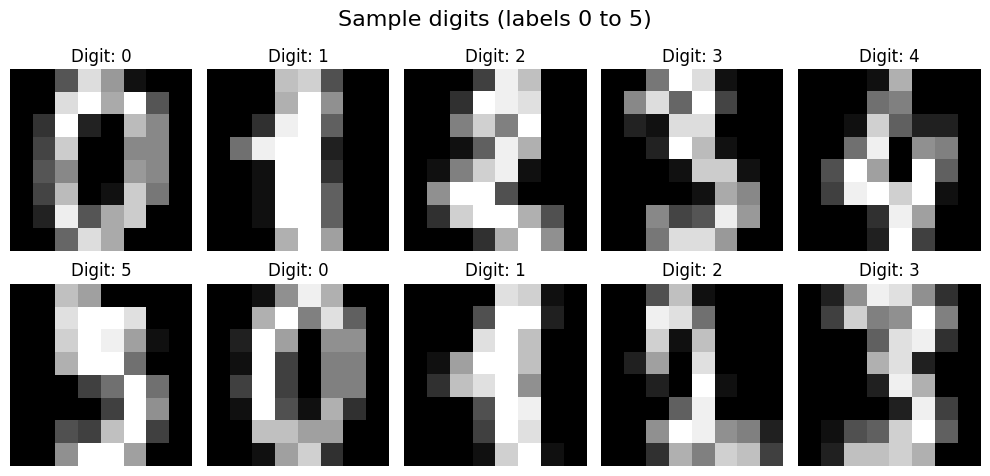

In [30]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding

digits = load_digits(n_class=6)
X, y = digits.data, digits.target

# Visualize a few sample digits
# Display 10 sample images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    # Reshape the i-th flattened image (64-d vector) to 8x8 for display
    ax.imshow(X[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Digit: {y[i]}")
    ax.axis('off')

plt.suptitle("Sample digits (labels 0 to 5)", fontsize=16)
plt.tight_layout()
plt.show()

Step 2

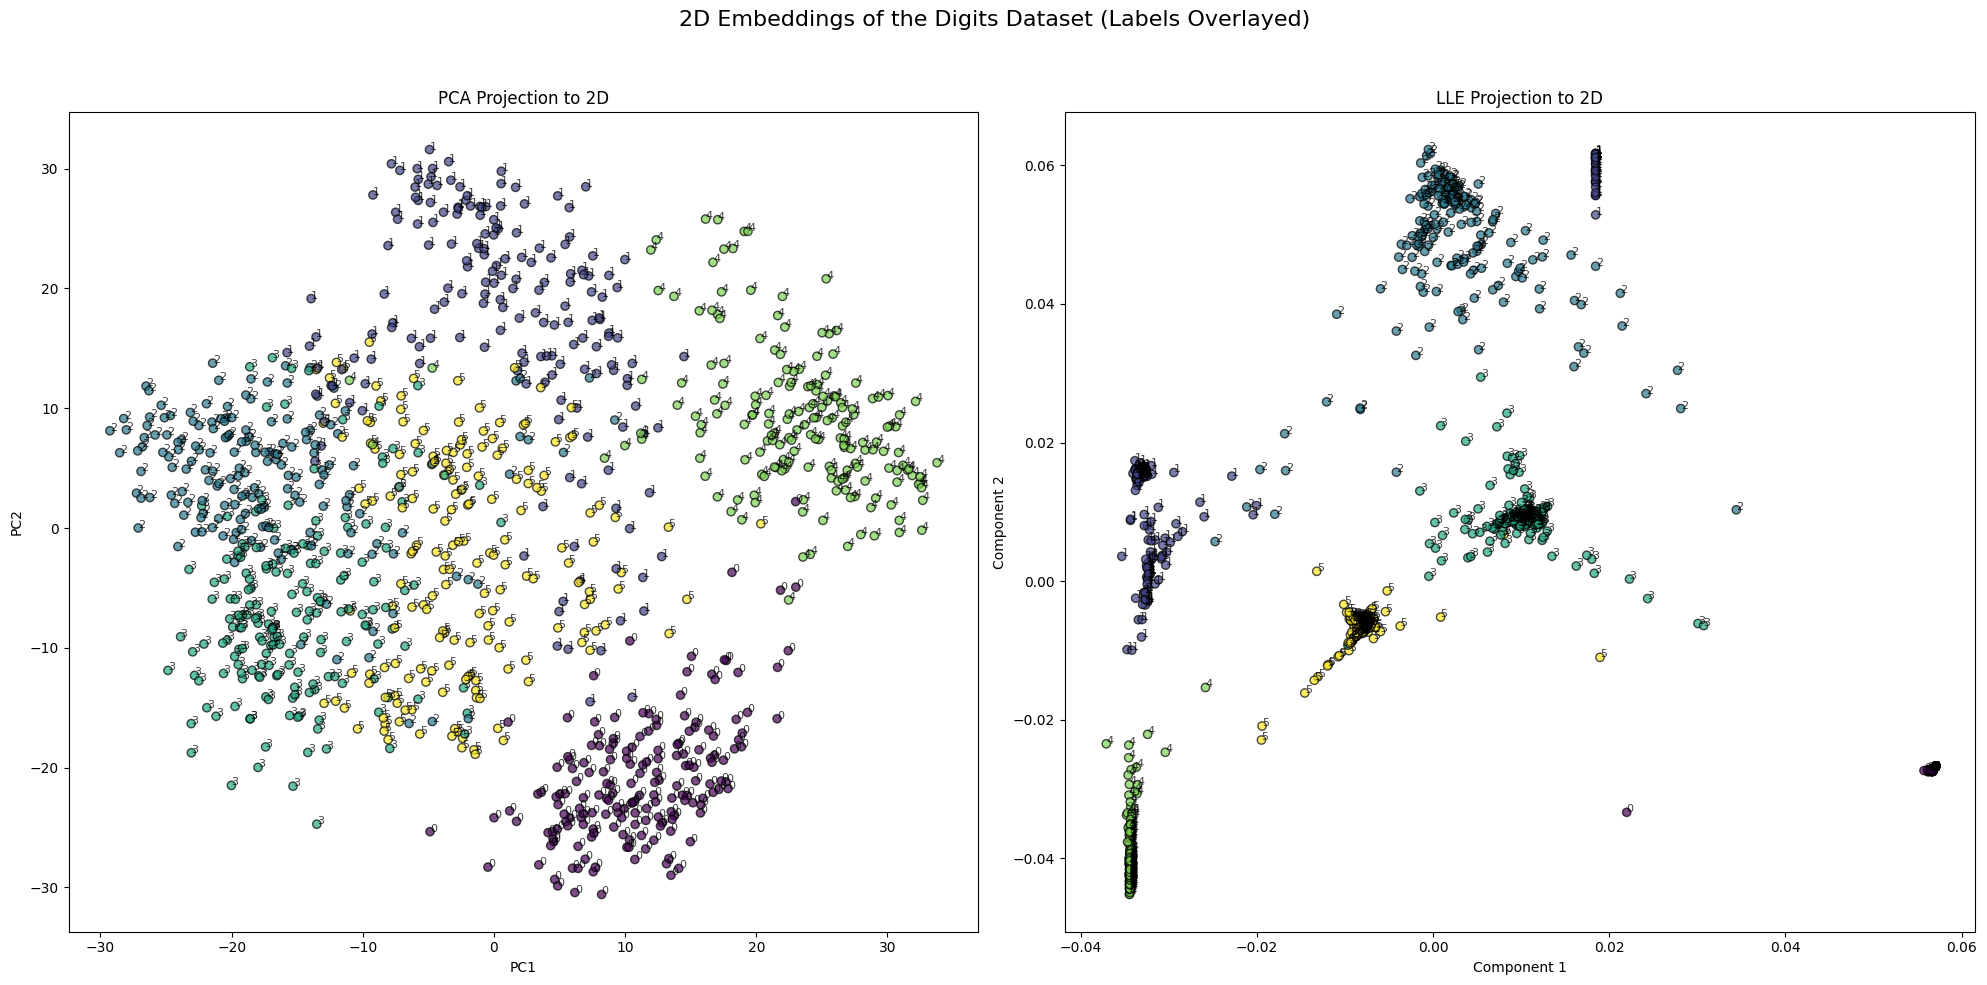

In [31]:
# --------------------------------------------------
# Apply PCA to project the data from 64D to 2D
# --------------------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# --------------------------------------------------
# Apply LLE to project the data from 64D to 2D
# set the number of neighbors to 10
# --------------------------------------------------
n_neighbors = 10
lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, random_state=42)
X_lle = lle.fit_transform(X)

# --------------------------------------------------
# Visualize the 2D embeddings in a side-by-side scatter plot,
# overlaying the true digit label for each point.
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# --- PCA Plot ---
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
for i, label in enumerate(y):
    axes[0].annotate(label, (X_pca[i, 0], X_pca[i, 1]), fontsize=8, alpha=0.75)
axes[0].set_title("PCA Projection to 2D")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")


# --- LLE Plot ---
axes[1].scatter(X_lle[:, 0], X_lle[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
for i, label in enumerate(y):
    axes[1].annotate(label, (X_lle[i, 0], X_lle[i, 1]), fontsize=8, alpha=0.75)
axes[1].set_title("LLE Projection to 2D")
axes[1].set_xlabel("Component 1")
axes[1].set_ylabel("Component 2")

plt.suptitle("2D Embeddings of the Digits Dataset (Labels Overlayed)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Step 3: Discuss the results in a brief paragraph:

LLE is a nonlinear method that better preserves local neighborhood relationships, which is better capture the separation of digit classes. PCA is a linear method, will force the components to be orthogonal and ”mix up” the actual directions when modes of variation are not orthogonal. In contrast, LLE is a nonlinear method, can generate highly non-linear embeddings.

Both PCA and LLE have their distinct trade-offs. PCA is computationally efficient and offers clear interpretability compared to LLE. LLE is a nonlinear technique that keeps local neighborhood relationships, resulting in improved cluster separation.

For instance, in this case, digits that share a similar variance pattern tended to overlap in PCA. Another example is when the data structure is linear; PCA tends to be more interpretable and computationally efficient. LLE provides better solution for problem of nonlinear dimensionality reduction.

Step 4

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score

# ------------------------------
# Evaluate the embeddings via a k-NN classifier in the 2D space
# ------------------------------
# use a simple k-NN (with k=3) to test the discriminative power.
knn = KNeighborsClassifier(n_neighbors=3)

# Evaluation with a train/test split for PCA embedding
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
knn.fit(X_train_pca, y_train)
pca_accuracy = knn.score(X_test_pca, y_test)

# Evaluation with a train/test split for LLE embedding
X_train_lle, X_test_lle, y_train, y_test = train_test_split(X_lle, y, test_size=0.3, random_state=42)
knn.fit(X_train_lle, y_train)
lle_accuracy = knn.score(X_test_lle, y_test)

print("k-NN classification accuracy in 2D PCA space: {:.2f}%".format(pca_accuracy * 100))
print("k-NN classification accuracy in 2D LLE space: {:.2f}%".format(lle_accuracy * 100))

# Also, using 5-fold cross validation to get a more robust evaluation:
cv_scores_pca = cross_val_score(KNeighborsClassifier(n_neighbors=3), X_pca, y, cv=5)
cv_scores_lle = cross_val_score(KNeighborsClassifier(n_neighbors=3), X_lle, y, cv=5)
print("5-fold CV accuracy in PCA space: {:.2f}% (std: {:.2f}%)".format(cv_scores_pca.mean() * 100, cv_scores_pca.std() * 100))
print("5-fold CV accuracy in LLE space: {:.2f}% (std: {:.2f}%)".format(cv_scores_lle.mean() * 100, cv_scores_lle.std() * 100))

k-NN classification accuracy in 2D PCA space: 85.85%
k-NN classification accuracy in 2D LLE space: 99.38%
5-fold CV accuracy in PCA space: 79.41% (std: 3.94%)
5-fold CV accuracy in LLE space: 98.06% (std: 1.03%)


From above analysis, the LLE better preserves the neighborhood structure. PCA shows more overlap for digits than LLE.

# Question 6

Step 1: Load and Visualize the Data.

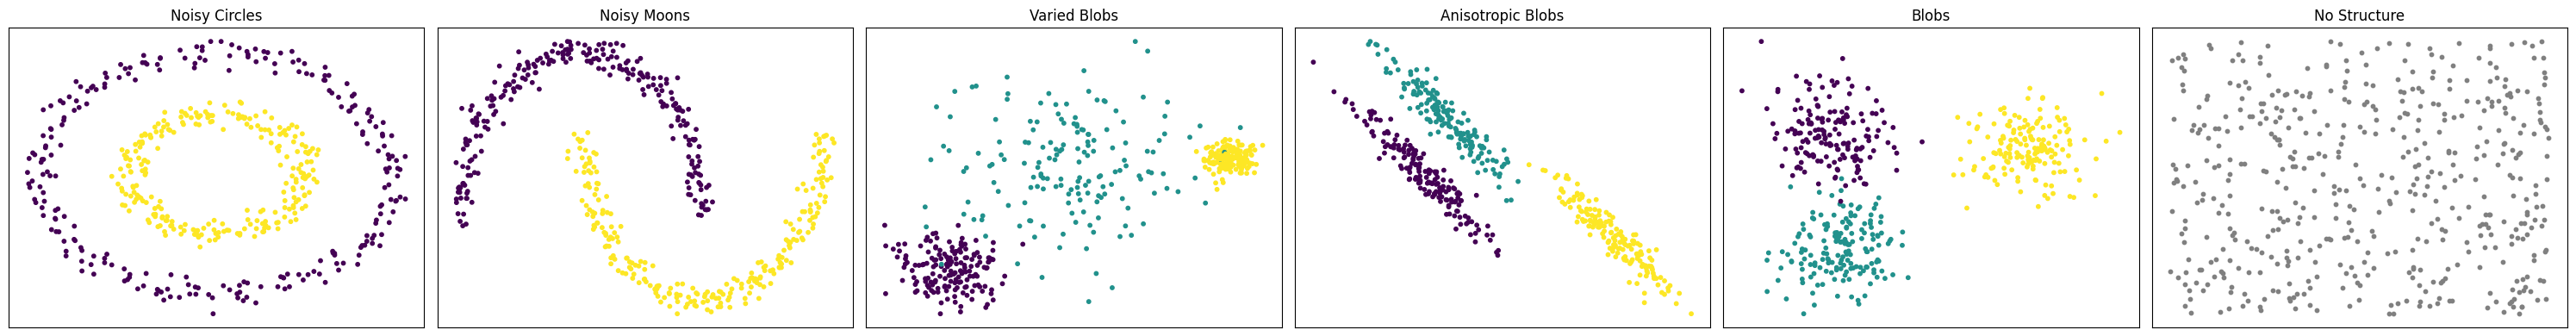

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

def generate_datasets(n_samples=500, seed=30):
    # Noisy Circles
    noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed)

    # Noisy Moons
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)

    # Blobs
    blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)

    # No Structure (random data)
    rng = np.random.RandomState(seed)
    no_structure = (rng.rand(n_samples, 2), None)

    # Anisotropicly distributed data
    random_state = 170
    X_blob, y_blob = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X_blob, transformation)
    aniso = (X_aniso, y_blob)

    # Blobs with varied variances
    varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

    data_dict = {
        "Noisy Circles": noisy_circles,
        "Noisy Moons": noisy_moons,
        "Varied Blobs": varied,
        "Anisotropic Blobs": aniso,
        "Blobs": blobs,
        "No Structure": no_structure,
    }

    # Normalization
    for key, (X, y) in data_dict.items():
        X = StandardScaler().fit_transform(X)
        data_dict[key] = (X, y)

    return data_dict

def plot_datasets(data_dict):
    n_datasets = len(data_dict)
    fig, axes = plt.subplots(1, n_datasets, figsize=(5 * n_datasets, 4))

    if n_datasets == 1:
        axes = [axes]

    for ax, (name, (X, y)) in zip(axes, data_dict.items()):
        if y is not None:
            ax.scatter(X[:, 0], X[:, 1], s=10, c=y, cmap='viridis')
        else:
            ax.scatter(X[:, 0], X[:, 1], s=10, color='gray')
        ax.set_title(name)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    data_dict = generate_datasets()
    plot_datasets(data_dict)

Step 2 & Step 3

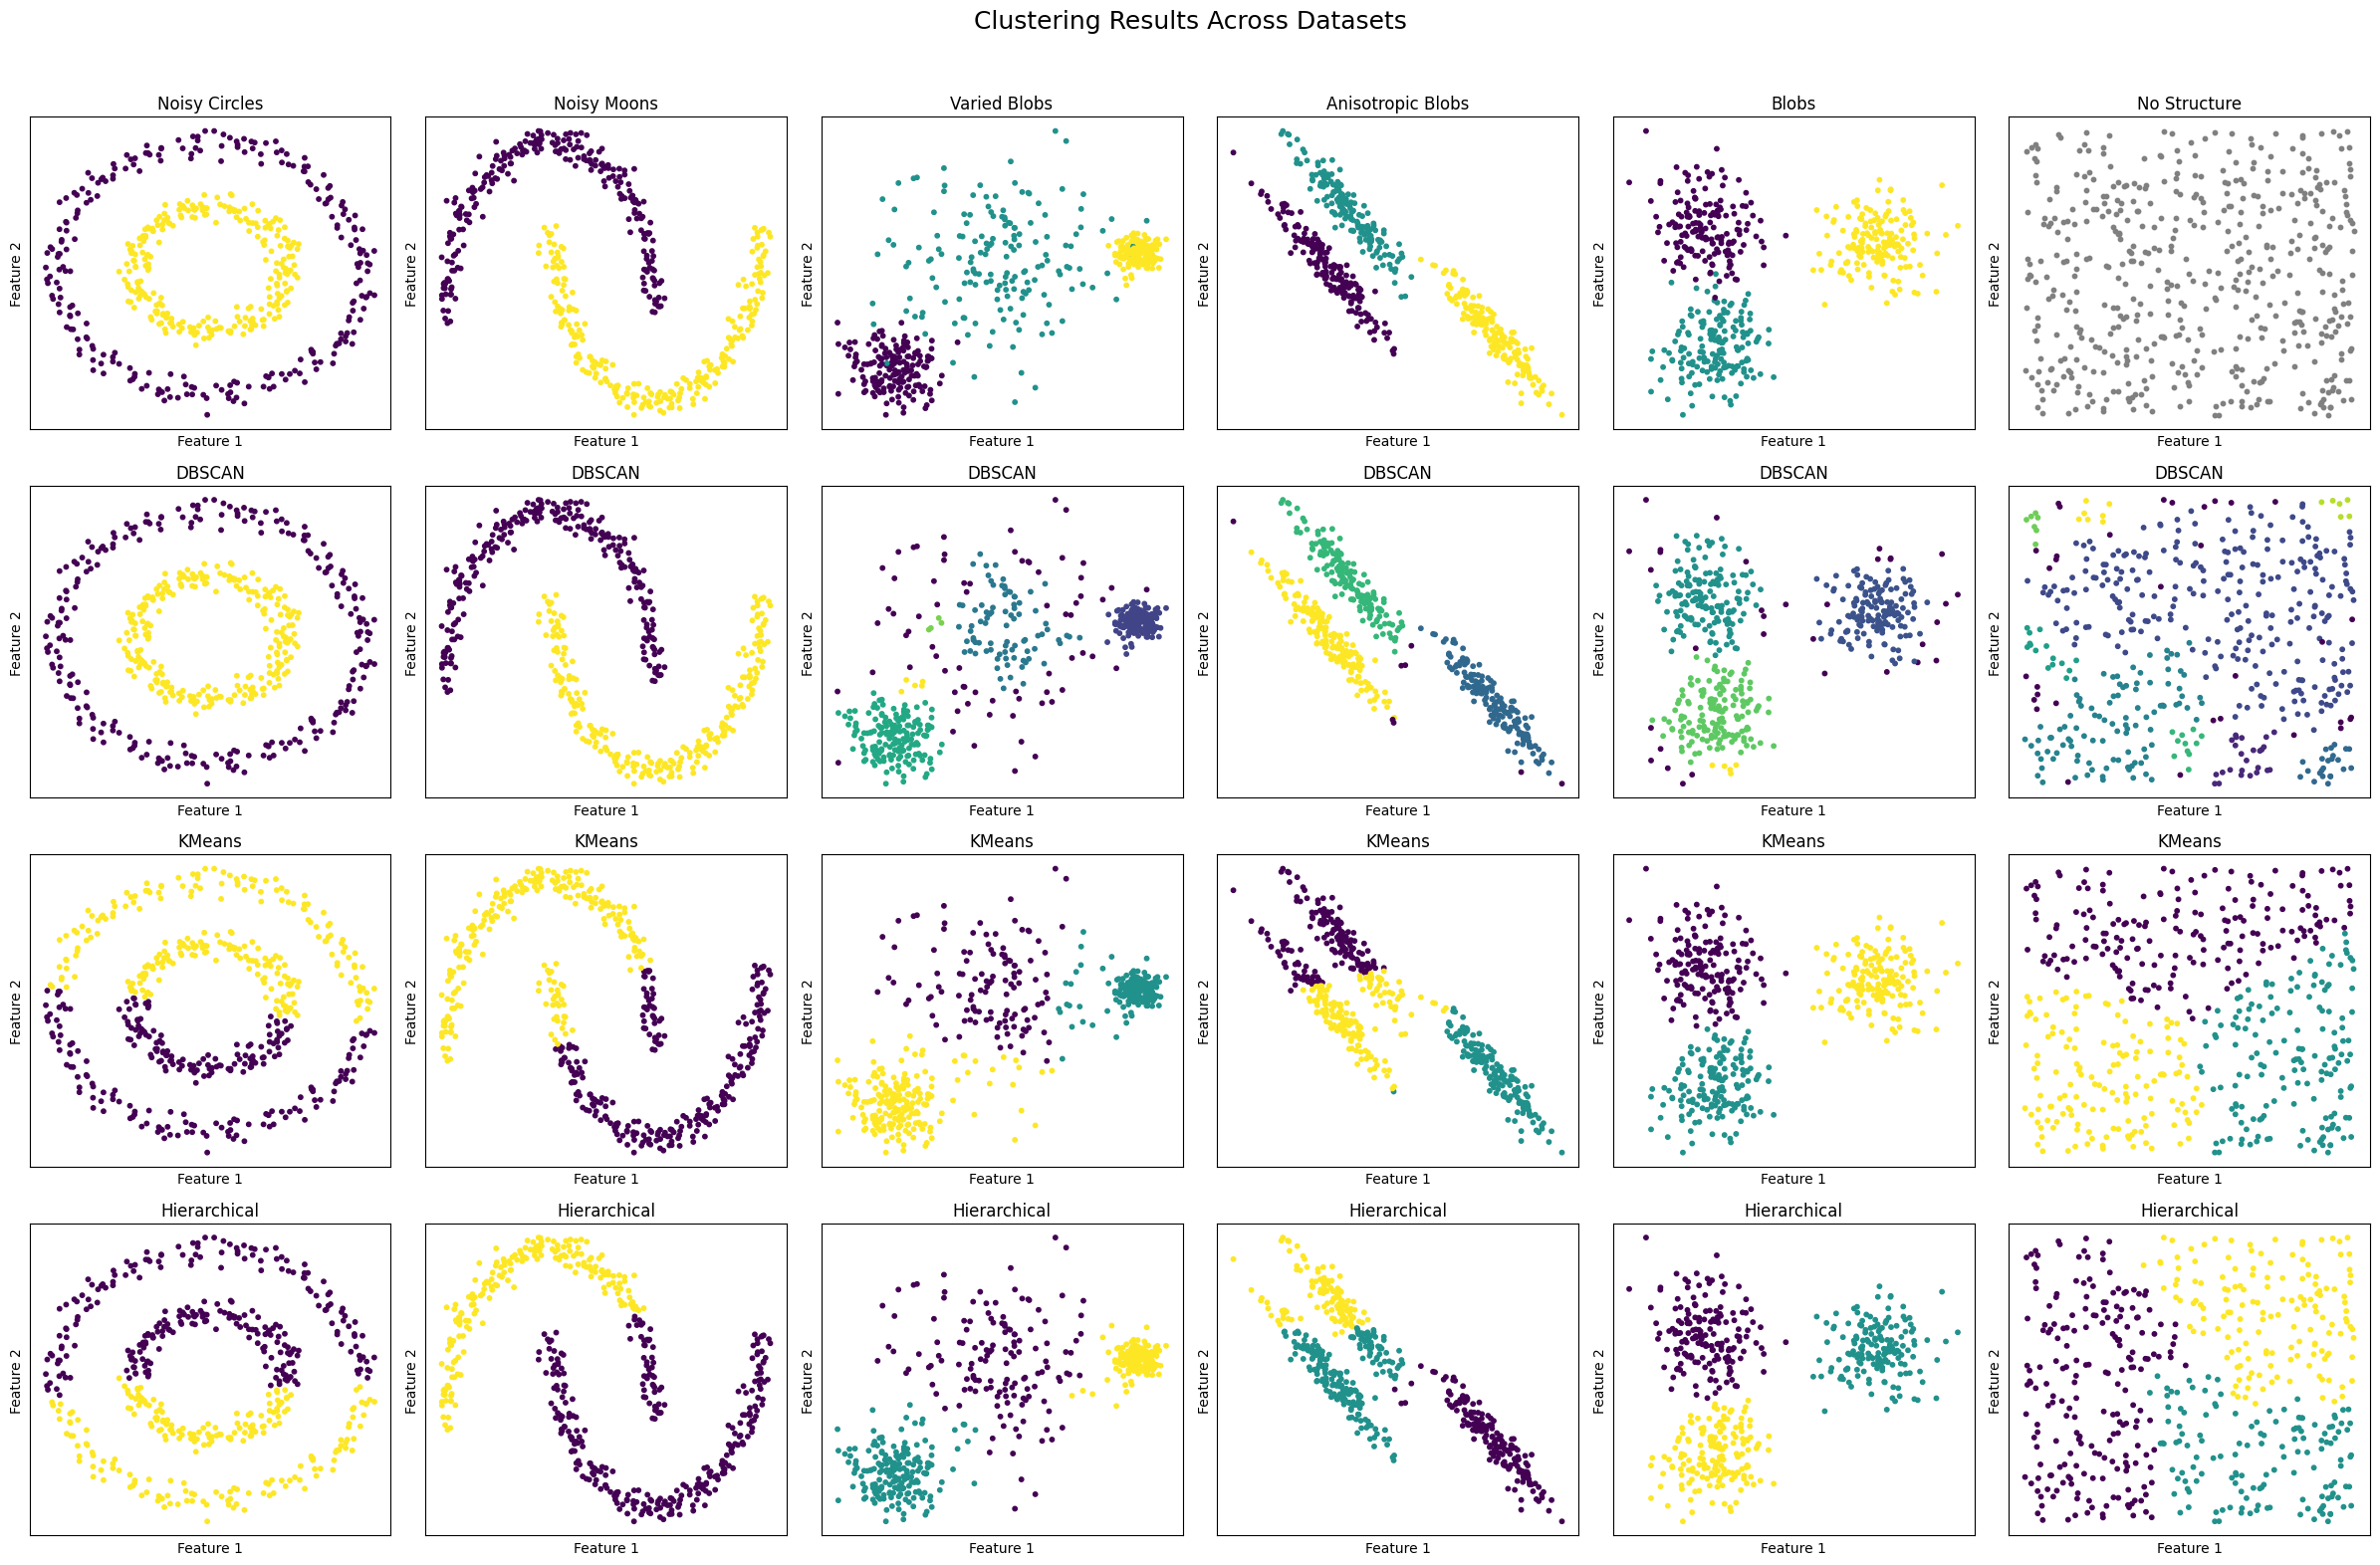

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

# Assume generate_datasets() returns a dictionary where each entry is:
# { "Dataset Name": (X_data, y_true), ... }
# data_dict = generate_datasets()

# Dictionary for the expected number of clusters (for KMeans and Agglomerative Clustering)
n_clusters_dict = {
    "Noisy Circles": 2,
    "Noisy Moons": 2,
    "Varied Blobs": 3,
    "Anisotropic Blobs": 3,
    "Blobs": 3,
    "No Structure": 3  # For 'no structure' we force 3 clusters to see what happens
}

# Dictionary for DBSCAN parameters (tuned per dataset as an example)
dbscan_params = {
    "Noisy Circles": {"eps": 0.3, "min_samples": 5},
    "Noisy Moons": {"eps": 0.2, "min_samples": 5},
    "Varied Blobs": {"eps": 0.2, "min_samples": 5},
    "Anisotropic Blobs": {"eps": 0.2, "min_samples": 5},
    "Blobs": {"eps": 0.2, "min_samples": 5},
    "No Structure": {"eps": 0.2, "min_samples": 5}
}

# Determine the number of datasets; each will be a column in our grid.
n_datasets = len(data_dict)
# We want 4 rows: 1st for ground truth, then DBSCAN, KMeans, Hierarchical Clustering.
n_rows = 4

# Create the grid of subplots.
fig, axes = plt.subplots(n_rows, n_datasets, figsize=(4 * n_datasets, 16))
fig.suptitle("Clustering Results Across Datasets", fontsize=18)

# Loop through each dataset (each column)
for col, (dataset_name, (X_data, y_true)) in enumerate(data_dict.items()):
    # Get expected number of clusters
    n_clusters = n_clusters_dict[dataset_name]

    # ---------------------------
    # Row 1: Ground Truth
    # ---------------------------
    ax = axes[0, col]
    if y_true is not None:
      scatter = ax.scatter(X_data[:, 0], X_data[:, 1], c=y_true, cmap='viridis', s=10)
    else:
      scatter = ax.scatter(X_data[:, 0], X_data[:, 1], color='grey', s=10)

    ax.set_title(dataset_name, fontsize=12)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_xticks([])
    ax.set_yticks([])


    # ---------------------------
    # Row 2: DBSCAN
    # ---------------------------
    params = dbscan_params[dataset_name]
    db = DBSCAN(eps=params["eps"], min_samples=params["min_samples"])
    labels_db = db.fit_predict(X_data)
    ax = axes[1, col]
    scatter = ax.scatter(X_data[:, 0], X_data[:, 1], c=labels_db, cmap='viridis', s=10)
    ax.set_title("DBSCAN", fontsize=12)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_xticks([])
    ax.set_yticks([])

    # ---------------------------
    # Row 3: KMeans
    # ---------------------------
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels_kmeans = kmeans.fit_predict(X_data)
    ax = axes[2, col]
    scatter = ax.scatter(X_data[:, 0], X_data[:, 1], c=labels_kmeans, cmap='viridis', s=10)
    ax.set_title("KMeans", fontsize=12)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_xticks([])
    ax.set_yticks([])

    # ---------------------------
    # Row 4: Hierarchical Clustering
    # ---------------------------
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    labels_agglo = agglo.fit_predict(X_data)
    ax = axes[3, col]
    scatter = ax.scatter(X_data[:, 0], X_data[:, 1], c=labels_agglo, cmap='viridis', s=10)
    ax.set_title("Hierarchical", fontsize=12)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


